In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS

# prepare dataframe for analysis

files_sources = {
    '../Output_Data/UBS/UBS_FT_prepped_20240526_224634_discrete.csv': 'FT',
    '../Output_Data/UBS/UBS_CNBC_prepped_20240526_224404_discrete.csv': 'CNBC',
    '../Output_Data/UBS/UBS_NZZ_prepped_20240526_231232_discrete.csv': 'NZZ',
    '../Output_Data/UBS/UBS_NZZ_prepped_correction_20240526_234112_discrete.csv': 'NZZ',
    '../Output_Data/UBS/UBS_SRF_prepped_20240526_234137_discrete.csv': 'SRF'
}

In [2]:
# Columns to keep
columns_to_keep = ["text_date", "Sentiment", "news_source"]

# Load datasets with a new 'news_source' column
data_frames = []
for file_path, source in files_sources.items():
    df = pd.read_csv(file_path)
    df['news_source'] = source  # Add news_source column
    # Select only the columns to keep
    df = df[columns_to_keep]
    data_frames.append(df)



In [3]:
# Merge all dataframes into a single dataframe
merged_df = pd.concat(data_frames)


In [4]:
# order by date
merged_df = merged_df.sort_values(by='text_date')

In [5]:
merged_df.tail()

,text_date,Sentiment,news_source
14,2023-06-28 00:00:00+00:00,-1. Article focuses on significant job cuts an...,NZZ
15,2023-06-28 00:00:00+00:00,"0. UBS analysts are mentioned neutrally, provi...",NZZ
16,2023-06-28 00:00:00+00:00,-1. Article highlights significant job cuts an...,NZZ
938,2023-06-29 00:00:00+00:00,1. Article portrays UBS's strategic decisions ...,FT
17,2023-06-29 00:00:00+00:00,-1. Article highlights UBS's cautious approach...,NZZ


In [6]:
# Extract numerical sentiment scores from the 'Sentiment' column
merged_df['Sentiment_score'] = merged_df['Sentiment'].str.extract(r"(-?\d\.?\d*)\.").astype(float)

In [7]:
# Convert 'text_date' to datetime format handling ISO8601 with timezone
merged_df['text_date'] = pd.to_datetime(merged_df['text_date'], errors='coerce', utc=True)

# Convert datetime to 'dd.mm.yyyy' format without time only after all datetime manipulations are done
merged_df['formatted_date'] = merged_df['text_date'].dt.strftime('%d.%m.%Y')

In [8]:
merged_df.head()

,text_date,Sentiment,news_source,Sentiment_score,formatted_date
0,2019-01-02 00:00:00+00:00,0. The article neutrally presents UBS's econom...,CNBC,0.0,02.01.2019
0,2019-01-03 00:00:00+00:00,-1. Article highlights UBS's shift to less ris...,NZZ,-1.0,03.01.2019
0,2019-01-03 00:00:00+00:00,0. The article neutrally presents UBS's analys...,FT,0.0,03.01.2019
1,2019-01-04 00:00:00+00:00,0. The article presents a balanced view on UBS...,NZZ,0.0,04.01.2019
1,2019-01-04 00:00:00+00:00,0. Article presents factual information with a...,FT,0.0,04.01.2019


In [9]:
len(merged_df)

2221

In [10]:
merged_df

,text_date,Sentiment,news_source,Sentiment_score,formatted_date
0,2019-01-02 00:00:00+00:00,0. The article neutrally presents UBS's econom...,CNBC,0.0,02.01.2019
0,2019-01-03 00:00:00+00:00,-1. Article highlights UBS's shift to less ris...,NZZ,-1.0,03.01.2019
0,2019-01-03 00:00:00+00:00,0. The article neutrally presents UBS's analys...,FT,0.0,03.01.2019
1,2019-01-04 00:00:00+00:00,0. The article presents a balanced view on UBS...,NZZ,0.0,04.01.2019
1,2019-01-04 00:00:00+00:00,0. Article presents factual information with a...,FT,0.0,04.01.2019
...,...,...,...,...,...
14,2023-06-28 00:00:00+00:00,-1. Article focuses on significant job cuts an...,NZZ,-1.0,28.06.2023
15,2023-06-28 00:00:00+00:00,"0. UBS analysts are mentioned neutrally, provi...",NZZ,0.0,28.06.2023
16,2023-06-28 00:00:00+00:00,-1. Article highlights significant job cuts an...,NZZ,-1.0,28.06.2023
938,2023-06-29 00:00:00+00:00,1. Article portrays UBS's strategic decisions ...,FT,1.0,29.06.2023


In [11]:
# Calculate daily average sentiment scores and create a new column 'D_AVG'
daily_sentiment = merged_df.groupby(merged_df['text_date'].dt.date).agg({
    'Sentiment_score': 'mean'  # Calculate the mean of Sentiment_score
}).reset_index().rename(columns={'Sentiment_score': 'D_AVG', 'text_date': 'Date'})

In [12]:
# Determine dummy variables based on the daily average sentiment score
daily_sentiment['Positive_sentiment'] = np.where(daily_sentiment['D_AVG'] >= 1/3, 1, 0)
daily_sentiment['Negative_sentiment'] = np.where(daily_sentiment['D_AVG'] <= -1/3, 1, 0)
daily_sentiment['Positive_sentiment_0'] = np.where(daily_sentiment['D_AVG'] >= 0, 1, 0)
daily_sentiment['Negative_sentiment_0'] = np.where(daily_sentiment['D_AVG'] <= 0, 1, 0)


In [13]:
# Convert 'Date' to datetime format
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'], format='%Y-%m-%d', errors='coerce')

In [14]:
daily_sentiment

,Date,D_AVG,Positive_sentiment,Negative_sentiment,Positive_sentiment_0,Negative_sentiment_0
0,2019-01-02,0.00,0,0,1,1
1,2019-01-03,-0.50,0,1,0,1
2,2019-01-04,0.00,0,0,1,1
3,2019-01-07,0.00,0,0,1,1
4,2019-01-08,-0.50,0,1,0,1
...,...,...,...,...,...,...
920,2023-06-25,0.00,0,0,1,1
921,2023-06-26,1.00,1,0,1,0
922,2023-06-27,-0.20,0,0,0,1
923,2023-06-28,-0.75,0,1,0,1


In [15]:
len(daily_sentiment)

925

In [16]:
# export csv files
merged_df.to_csv('merged_df_ubs.csv', index=False)
daily_sentiment.to_csv('daily_sentiment_ubs.csv', index=False)

In [17]:
# Read in financial data
ubs_stocks = pd.read_csv('UBS_stocks.csv', sep=";")

In [18]:
# Convert 'Date' column to datetime format (dd.mm.yyyy)
ubs_stocks['Date'] = pd.to_datetime(ubs_stocks['Date'], format='%d.%m.%Y', errors='coerce')

In [19]:
ubs_stocks

,Date,PX_LAST,PX_VOLUME
0,2023-06-13,18.430,4632276
1,2023-06-12,18.350,7240074
2,2023-06-09,18.200,4690324
3,2023-06-08,18.255,4751312
4,2023-06-07,18.270,4294790
...,...,...,...
1116,2019-01-08,12.720,12715444
1117,2019-01-07,12.645,11118218
1118,2019-01-04,12.620,12969952
1119,2019-01-03,12.245,13928578


In [20]:
# Calculate log returns (shift(-1) because dataframe is in descending order)
ubs_stocks['Log_Return'] = np.log(ubs_stocks['PX_LAST'] / ubs_stocks['PX_LAST'].shift(-1))

In [21]:
ubs_stocks

,Date,PX_LAST,PX_VOLUME,Log_Return
0,2023-06-13,18.430,4632276,0.004350
1,2023-06-12,18.350,7240074,0.008208
2,2023-06-09,18.200,4690324,-0.003017
3,2023-06-08,18.255,4751312,-0.000821
4,2023-06-07,18.270,4294790,0.000274
...,...,...,...,...
1116,2019-01-08,12.720,12715444,0.005914
1117,2019-01-07,12.645,11118218,0.001979
1118,2019-01-04,12.620,12969952,0.030165
1119,2019-01-03,12.245,13928578,0.000817


In [22]:
# Drop the last row with NaN return
ubs_stocks = ubs_stocks.dropna(subset=['Log_Return'])

In [23]:
#Create a complete date range
date_range = pd.date_range(start=min(ubs_stocks['Date'].min(), daily_sentiment['Date'].min()),
                           end=max(ubs_stocks['Date'].max(), daily_sentiment['Date'].max()))

# Reindex the datasets to this date range
ubs_stocks = ubs_stocks.set_index('Date').reindex(date_range).ffill().reset_index().rename(columns={'index': 'Date'})
daily_sentiment = daily_sentiment.set_index('Date').reindex(date_range).fillna({'D_AVG': 0, 'Positive_sentiment': 0, 'Negative_sentiment': 0, 'Positive_sentiment_0': 0, 'Negative_sentiment_0': 0}).reset_index().rename(columns={'index': 'Date'})

In [24]:
# Merge datasets on date
merged_data = pd.merge(ubs_stocks, daily_sentiment, on='Date', how='inner')

In [25]:
#somehow first row still has NA (only first row)
merged_data = merged_data.dropna()

In [26]:
merged_data

,Date,PX_LAST,PX_VOLUME,Log_Return,D_AVG,Positive_sentiment,Negative_sentiment,Positive_sentiment_0,Negative_sentiment_0
1,2019-01-03,12.245,13928578.0,0.000817,-0.50,0.0,1.0,0.0,1.0
2,2019-01-04,12.620,12969952.0,0.030165,0.00,0.0,0.0,1.0,1.0
3,2019-01-05,12.620,12969952.0,0.030165,0.00,0.0,0.0,0.0,0.0
4,2019-01-06,12.620,12969952.0,0.030165,0.00,0.0,0.0,0.0,0.0
5,2019-01-07,12.645,11118218.0,0.001979,0.00,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
1635,2023-06-25,18.430,4632276.0,0.004350,0.00,0.0,0.0,1.0,1.0
1636,2023-06-26,18.430,4632276.0,0.004350,1.00,1.0,0.0,1.0,0.0
1637,2023-06-27,18.430,4632276.0,0.004350,-0.20,0.0,0.0,0.0,1.0
1638,2023-06-28,18.430,4632276.0,0.004350,-0.75,0.0,1.0,0.0,1.0


In [27]:
len(merged_data)

1639

In [28]:
# Filter merged_data by the date range 2019-01-01 to 2023-03-12
filtered_start_date = '2019-01-01'
filtered_end_date = '2023-03-17'
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
merged_data = merged_data[(merged_data['Date'] >= filtered_start_date) & (merged_data['Date'] <= filtered_end_date)]

In [29]:
merged_data

,Date,PX_LAST,PX_VOLUME,Log_Return,D_AVG,Positive_sentiment,Negative_sentiment,Positive_sentiment_0,Negative_sentiment_0
1,2019-01-03,12.245,13928578.0,0.000817,-0.50,0.0,1.0,0.0,1.0
2,2019-01-04,12.620,12969952.0,0.030165,0.00,0.0,0.0,1.0,1.0
3,2019-01-05,12.620,12969952.0,0.030165,0.00,0.0,0.0,0.0,0.0
4,2019-01-06,12.620,12969952.0,0.030165,0.00,0.0,0.0,0.0,0.0
5,2019-01-07,12.645,11118218.0,0.001979,0.00,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
1531,2023-03-13,17.710,28227523.0,-0.079739,0.00,0.0,0.0,1.0,1.0
1532,2023-03-14,18.340,16297012.0,0.034955,-1.00,0.0,1.0,0.0,1.0
1533,2023-03-15,16.740,27387600.0,-0.091283,0.00,0.0,0.0,0.0,0.0
1534,2023-03-16,17.310,26105212.0,0.033483,0.25,0.0,0.0,1.0,0.0


### Analysis

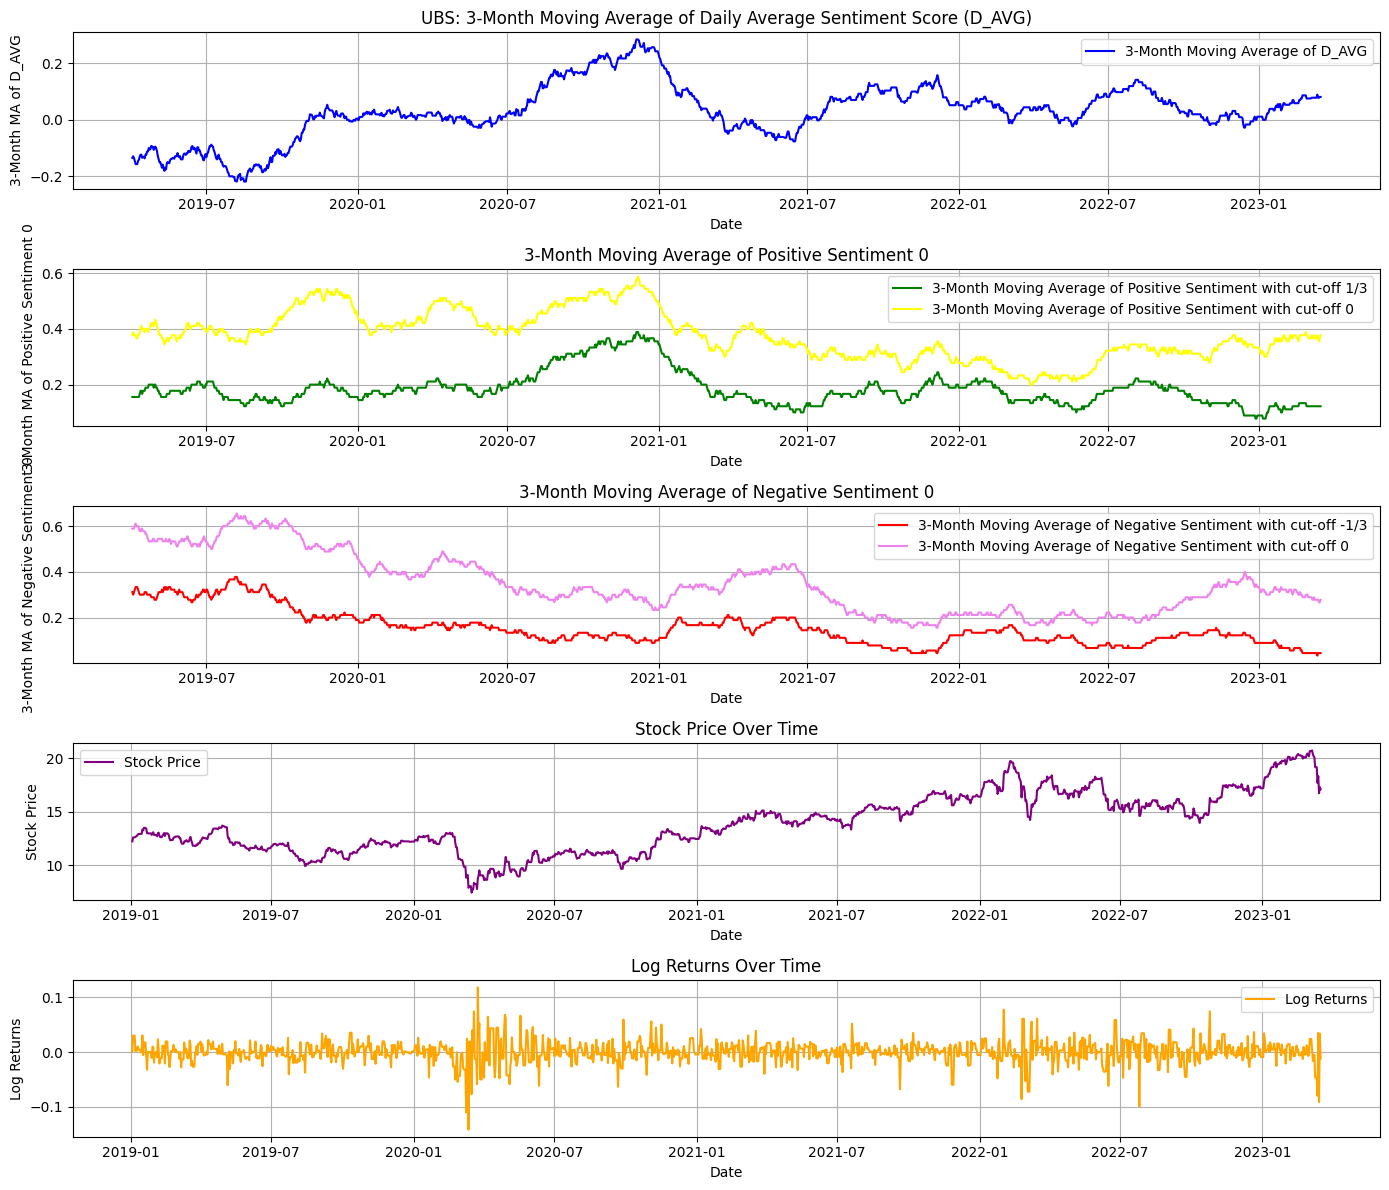

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
#create copy of merged_data
merged_data_plots = merged_data.copy()
# Assuming merged_data is already defined and contains the relevant columns

# Calculate the 3-month (90-day) moving averages
merged_data_plots['D_AVG_MA_3M'] = merged_data_plots['D_AVG'].rolling(window=90).mean()
merged_data_plots['Positive_sentiment_MA_3M'] = merged_data_plots['Positive_sentiment'].rolling(window=90).mean()
merged_data_plots['Negative_sentiment_MA_3M'] = merged_data_plots['Negative_sentiment'].rolling(window=90).mean()
merged_data_plots['Positive_sentiment_0_MA_3M'] = merged_data_plots['Positive_sentiment_0'].rolling(window=90).mean()
merged_data_plots['Negative_sentiment_0_MA_3M'] = merged_data_plots['Negative_sentiment_0'].rolling(window=90).mean()

# Plot the 3-month moving averages, stock price, and log returns
plt.figure(figsize=(14, 12))

# Plot for D_AVG
plt.subplot(5, 1, 1)
plt.plot(merged_data_plots['Date'], merged_data_plots['D_AVG_MA_3M'], label='3-Month Moving Average of D_AVG', color='blue')
plt.xlabel('Date')
plt.ylabel('3-Month MA of D_AVG')
plt.title('UBS: 3-Month Moving Average of Daily Average Sentiment Score (D_AVG)')
plt.legend()
plt.grid(True)

# Plot for Positive_sentiment
plt.subplot(5, 1, 2)
plt.plot(merged_data_plots['Date'], merged_data_plots['Positive_sentiment_MA_3M'], label='3-Month Moving Average of Positive Sentiment with cut-off 1/3', color='green')
plt.xlabel('Date')
plt.ylabel('3-Month MA of Positive Sentiment')
plt.title('3-Month Moving Average of Positive Sentiment')
plt.legend()
plt.grid(True)

# Plot for Negative_sentiment
plt.subplot(5, 1, 3)
plt.plot(merged_data_plots['Date'], merged_data_plots['Negative_sentiment_MA_3M'], label='3-Month Moving Average of Negative Sentiment with cut-off -1/3', color='red')
plt.xlabel('Date')
plt.ylabel('3-Month MA of Negative Sentiment')
plt.title('3-Month Moving Average of Negative Sentiment')
plt.legend()
plt.grid(True)


# Plot for Positive_sentiment_0
plt.subplot(5, 1, 2)
plt.plot(merged_data_plots['Date'], merged_data_plots['Positive_sentiment_0_MA_3M'], label='3-Month Moving Average of Positive Sentiment with cut-off 0', color='yellow')
plt.xlabel('Date')
plt.ylabel('3-Month MA of Positive Sentiment 0')
plt.title('3-Month Moving Average of Positive Sentiment 0')
plt.legend()
plt.grid(True)

# Plot for Negative_sentiment_0
plt.subplot(5, 1, 3)
plt.plot(merged_data_plots['Date'], merged_data_plots['Negative_sentiment_0_MA_3M'], label='3-Month Moving Average of Negative Sentiment with cut-off 0', color='violet')
plt.xlabel('Date')
plt.ylabel('3-Month MA of Negative Sentiment 0')
plt.title('3-Month Moving Average of Negative Sentiment 0')
plt.legend()
plt.grid(True)



# Plot for stock price
plt.subplot(5, 1, 4)
plt.plot(merged_data_plots['Date'], merged_data_plots['PX_LAST'], label='Stock Price', color='purple')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Over Time')
plt.legend()
plt.grid(True)

# Plot for log returns
plt.subplot(5, 1, 5)
plt.plot(merged_data_plots['Date'], merged_data_plots['Log_Return'], label='Log Returns', color='orange')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('Log Returns Over Time')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


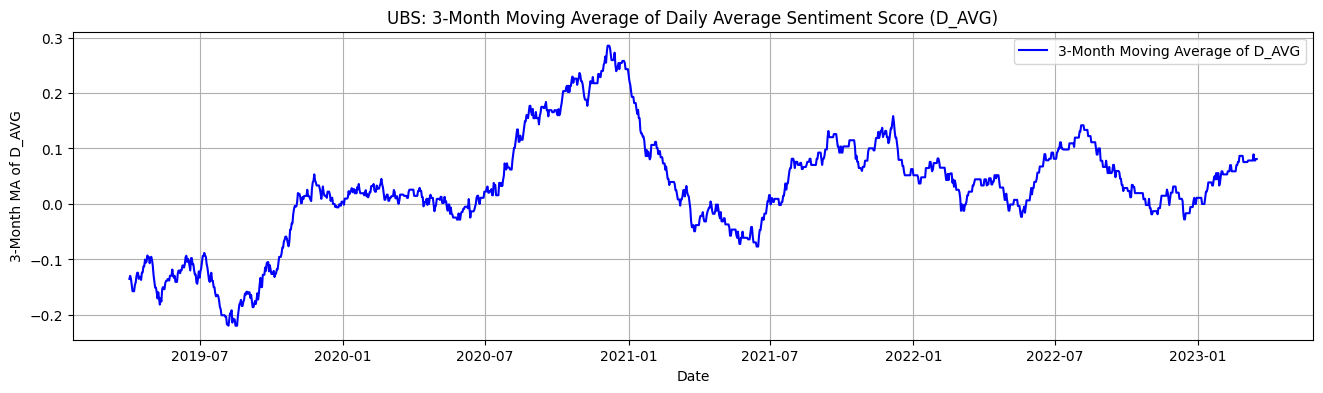

In [31]:
# Create a separate plot for the 3-month moving average of D_AVG
plt.figure(figsize=(16, 4))
plt.plot(merged_data_plots['Date'], merged_data_plots['D_AVG_MA_3M'], label='3-Month Moving Average of D_AVG', color='blue')
plt.xlabel('Date')
plt.ylabel('3-Month MA of D_AVG')
plt.title('UBS: 3-Month Moving Average of Daily Average Sentiment Score (D_AVG)')
plt.legend()
plt.grid(True)
plt.show()

ACF values: [ 1.          0.25959559  0.12637887 -0.01524494 -0.0028704  -0.00875744
  0.01632064  0.05323246 -0.0330034   0.00378814  0.02792475  0.08009994
 -0.0179983   0.00671361 -0.00165094 -0.06027269 -0.00162118  0.00780956
  0.00927284  0.01095739 -0.00360088 -0.03316053 -0.02284854 -0.01740016
 -0.02966441 -0.07202477 -0.06104726 -0.02987651 -0.03763671  0.00784265
 -0.02662731 -0.03618834]


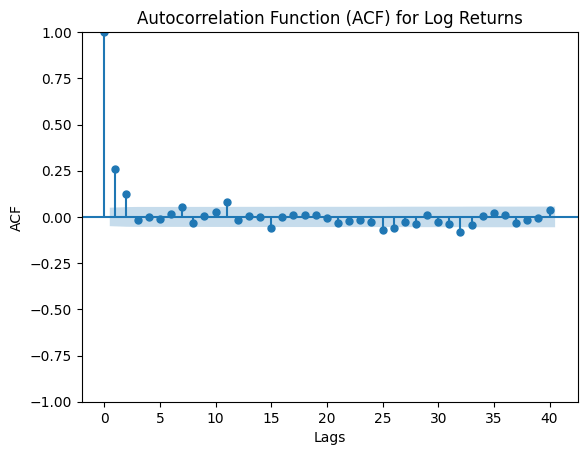

In [32]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Assuming 'merged_data' already contains the 'Log_Return' column

# Calculate ACF values for the log stock returns
acf_values = sm.tsa.stattools.acf(merged_data['Log_Return'], fft=False)

# Print the ACF values
print("ACF values:", acf_values)

# Plot the ACF
plot_acf(merged_data['Log_Return'], lags=40)  # You can adjust the number of lags as needed
plt.title('Autocorrelation Function (ACF) for Log Returns')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

PACF values: [ 1.00000000e+00  2.59764821e-01  6.33400242e-02 -6.73116952e-02
  8.97840540e-03 -4.30726148e-04  1.80563925e-02  4.97231456e-02
 -6.72965705e-02  1.99715621e-02  4.15550493e-02  6.29650138e-02
 -6.42281885e-02  1.21347602e-02  9.01807387e-03 -6.65355403e-02
  2.92796258e-02  1.00031577e-02 -9.58695127e-03  2.45277058e-02
 -2.03834359e-02 -3.77331396e-02  2.78411263e-03 -7.54615624e-03
 -3.18583637e-02 -5.99114036e-02 -1.82721746e-02 -4.84987357e-03
 -2.67647196e-02  2.39262474e-02 -4.25914899e-02 -2.08603100e-02
 -5.32827975e-02 -1.70042764e-02  3.65494306e-02  2.22439827e-02
 -9.62137428e-03 -3.43880562e-02  4.32380569e-03  1.28234998e-02
  2.91317758e-02]


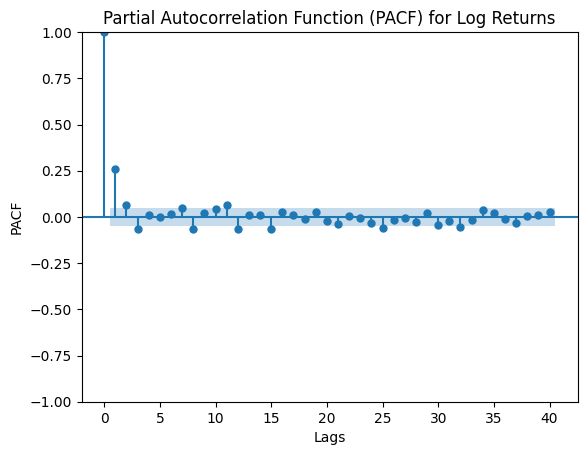

In [33]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# Assuming 'merged_data' already contains the 'Log_Return' column

# Calculate PACF values for the log stock returns
pacf_values = sm.tsa.stattools.pacf(merged_data['Log_Return'], method='yw', nlags=40)

# Print the PACF values
print("PACF values:", pacf_values)

# Plot the PACF
plot_pacf(merged_data['Log_Return'], lags=40, method='yw')  # You can adjust the number of lags as needed
plt.title('Partial Autocorrelation Function (PACF) for Log Returns')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

### Models

In [34]:
merged_data_a1 = merged_data.copy()

In [35]:
merged_data_a1.loc[:, 'Log_Return_Lag1'] = merged_data_a1['Log_Return'].shift(1)
merged_data_a1.loc[:, 'Log_Return_Lag2'] = merged_data_a1['Log_Return'].shift(2)
merged_data_a1.loc[:, 'Log_Return_Lag3'] = merged_data_a1['Log_Return'].shift(3)
merged_data_a1.loc[:, 'Log_Return_Lag7'] = merged_data_a1['Log_Return'].shift(7)
merged_data_a1.loc[:, 'Log_Return_Lag8'] = merged_data_a1['Log_Return'].shift(8)



In [36]:
merged_data_a1.head()

,Date,PX_LAST,PX_VOLUME,Log_Return,D_AVG,Positive_sentiment,Negative_sentiment,Positive_sentiment_0,Negative_sentiment_0,Log_Return_Lag1,Log_Return_Lag2,Log_Return_Lag3,Log_Return_Lag7,Log_Return_Lag8
1,2019-01-03,12.245,13928578.0,0.000817,-0.5,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
2,2019-01-04,12.620,12969952.0,0.030165,0.0,0.0,0.0,1.0,1.0,0.000817,NaN,NaN,NaN,NaN
3,2019-01-05,12.620,12969952.0,0.030165,0.0,0.0,0.0,0.0,0.0,0.030165,0.000817,NaN,NaN,NaN
4,2019-01-06,12.620,12969952.0,0.030165,0.0,0.0,0.0,0.0,0.0,0.030165,0.030165,0.000817,NaN,NaN
5,2019-01-07,12.645,11118218.0,0.001979,0.0,0.0,0.0,1.0,1.0,0.030165,0.030165,0.030165,NaN,NaN


In [37]:


# Drop rows with NaN values created by the shift operation
merged_data_a1.dropna(inplace=True)

# Define the model with sentiment scores and lagged returns as predictors
X = merged_data_a1[['Positive_sentiment', 'Negative_sentiment', 'Log_Return_Lag1', 'Log_Return_Lag2','Log_Return_Lag3','Log_Return_Lag7', 'Log_Return_Lag8']]
X = sm.add_constant(X)  # Adding a constant
y = merged_data_a1['Log_Return']

# Fit the model
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     10.01
Date:                Mon, 29 Jul 2024   Prob (F-statistic):           2.78e-12
Time:                        22:26:28   Log-Likelihood:                 3914.9
No. Observations:                1527   AIC:                            -7814.
Df Residuals:                    1519   BIC:                            -7771.
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -3.56e-05      0

In [38]:
merged_data_a2 = merged_data.copy()
#Lag variables
merged_data_a2.loc[:, 'Log_Return_Lag1'] = merged_data_a2['Log_Return'].shift(1)
merged_data_a2.loc[:, 'Log_Return_Lag2'] = merged_data_a2['Log_Return'].shift(2)
merged_data_a2.loc[:, 'Positive_sentiment_Lag1'] = merged_data_a2['Positive_sentiment'].shift(1)
merged_data_a2.loc[:, 'Positive_sentiment_0_Lag1'] = merged_data_a2['Positive_sentiment_0'].shift(1)
merged_data_a2.loc[:, 'Negative_sentiment_Lag1'] = merged_data_a2['Negative_sentiment'].shift(1)
merged_data_a2.loc[:, 'Negative_sentiment_0_Lag1'] = merged_data_a2['Negative_sentiment_0'].shift(1)


# Drop rows with NaN values created by the shift operation
merged_data_a2.dropna(inplace=True)

# Define the model with sentiment scores and lagged returns as predictors
X = merged_data_a2[['Positive_sentiment', 'Negative_sentiment', 'Positive_sentiment_Lag1', 'Negative_sentiment_Lag1', 'Log_Return_Lag1', 'Log_Return_Lag2']]
X = sm.add_constant(X)  # Adding a constant
y = merged_data_a2['Log_Return']

# Fit the model
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     10.10
Date:                Mon, 29 Jul 2024   Prob (F-statistic):           5.66e-11
Time:                        22:26:32   Log-Likelihood:                 3924.4
No. Observations:                1533   AIC:                            -7835.
Df Residuals:                    1526   BIC:                            -7797.
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [39]:
merged_data_a2

,Date,PX_LAST,PX_VOLUME,Log_Return,D_AVG,Positive_sentiment,Negative_sentiment,Positive_sentiment_0,Negative_sentiment_0,Log_Return_Lag1,Log_Return_Lag2,Positive_sentiment_Lag1,Positive_sentiment_0_Lag1,Negative_sentiment_Lag1,Negative_sentiment_0_Lag1
3,2019-01-05,12.620,12969952.0,0.030165,0.00,0.0,0.0,0.0,0.0,0.030165,0.000817,0.0,1.0,0.0,1.0
4,2019-01-06,12.620,12969952.0,0.030165,0.00,0.0,0.0,0.0,0.0,0.030165,0.030165,0.0,0.0,0.0,0.0
5,2019-01-07,12.645,11118218.0,0.001979,0.00,0.0,0.0,1.0,1.0,0.030165,0.030165,0.0,0.0,0.0,0.0
6,2019-01-08,12.720,12715444.0,0.005914,-0.50,0.0,1.0,0.0,1.0,0.001979,0.030165,0.0,1.0,0.0,1.0
7,2019-01-09,12.750,10547375.0,0.002356,-1.00,0.0,1.0,0.0,1.0,0.005914,0.001979,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,2023-03-13,17.710,28227523.0,-0.079739,0.00,0.0,0.0,1.0,1.0,-0.046354,-0.046354,0.0,0.0,0.0,0.0
1532,2023-03-14,18.340,16297012.0,0.034955,-1.00,0.0,1.0,0.0,1.0,-0.079739,-0.046354,0.0,1.0,0.0,1.0
1533,2023-03-15,16.740,27387600.0,-0.091283,0.00,0.0,0.0,0.0,0.0,0.034955,-0.079739,0.0,0.0,1.0,1.0
1534,2023-03-16,17.310,26105212.0,0.033483,0.25,0.0,0.0,1.0,0.0,-0.091283,0.034955,0.0,0.0,0.0,0.0


In [40]:
# Define the model with sentiment scores and lagged returns as predictors
X = merged_data_a2[['Positive_sentiment_0', 'Negative_sentiment_0', 'Log_Return_Lag1', 'Log_Return_Lag2']]
X = sm.add_constant(X)  # Adding a constant
y = merged_data_a2['Log_Return']

# Fit the model
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     15.47
Date:                Mon, 29 Jul 2024   Prob (F-statistic):           2.06e-12
Time:                        22:26:40   Log-Likelihood:                 3924.2
No. Observations:                1533   AIC:                            -7838.
Df Residuals:                    1528   BIC:                            -7812.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0006 

In [41]:
# Define the model with sentiment scores and lagged returns as predictors
X = merged_data_a2[['Positive_sentiment_0', 'Negative_sentiment_0','Positive_sentiment_0_Lag1', 'Negative_sentiment_0_Lag1', 'Log_Return_Lag1', 'Log_Return_Lag2']]
X = sm.add_constant(X)  # Adding a constant
y = merged_data_a2['Log_Return']

# Fit the model
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     10.74
Date:                Mon, 29 Jul 2024   Prob (F-statistic):           1.01e-11
Time:                        22:26:43   Log-Likelihood:                 3925.6
No. Observations:                1533   AIC:                            -7837.
Df Residuals:                    1526   BIC:                            -7800.
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

#### index

In [42]:
# Load the stock index data with the correct delimiter
mxeu_df = pd.read_csv('MXEU.csv', delimiter=';')
smi_df = pd.read_csv('SMI.csv', delimiter=';')
spx_df = pd.read_csv('SPX.csv', delimiter=';')
sx7p_df = pd.read_csv('SX7P.csv', delimiter=';')





In [43]:
mxeu_df.head()

,Date,PX_LAST,PX_VOLUME
0,24.05.2024,173.01550,1.453675e+09
1,23.05.2024,173.02624,1.577289e+09
2,22.05.2024,173.06490,1.435591e+09
3,21.05.2024,173.26201,1.494578e+09
4,20.05.2024,173.47093,1.124512e+09


In [44]:


# Define fixed start and end dates
start_date = '2019-01-01'
end_date = '2023-03-17'
date_range = pd.date_range(start=start_date, end=end_date)

# Function to reindex and fill missing data
def reindex_and_fill(df, date_col='Date'):
    df[date_col] = pd.to_datetime(df[date_col],dayfirst=True,errors='coerce')
    df = df.drop_duplicates(subset=date_col)
    df = df.set_index(date_col).reindex(date_range).ffill().reset_index().rename(columns={'index': date_col})
    return df

# Reindex and fill missing data for stock index dataframes
mxeu_df = reindex_and_fill(mxeu_df)
smi_df = reindex_and_fill(smi_df)
spx_df = reindex_and_fill(spx_df)
sx7p_df = reindex_and_fill(sx7p_df)

# Calculate the natural logarithm of the index prices
mxeu_df['Log_MXEU'] = np.log(mxeu_df['PX_LAST'])
smi_df['Log_SMI'] = np.log(smi_df['PX_LAST'])
spx_df['Log_SPX'] = np.log(spx_df['PX_LAST'])
sx7p_df['Log_SX7P'] = np.log(sx7p_df['PX_LAST'])

# Calculate the difference in log to get log returns
mxeu_df['Log_Return_MXEU'] = mxeu_df['Log_MXEU'].diff()
smi_df['Log_Return_SMI'] = smi_df['Log_SMI'].diff()
spx_df['Log_Return_SPX'] = spx_df['Log_SPX'].diff()
sx7p_df['Log_Return_SX7P'] = sx7p_df['Log_SX7P'].diff()

# Keep only the 'Date' and log return columns
mxeu_df = mxeu_df[['Date', 'Log_Return_MXEU']]
smi_df = smi_df[['Date', 'Log_Return_SMI']]
spx_df = spx_df[['Date', 'Log_Return_SPX']]
sx7p_df = sx7p_df[['Date', 'Log_Return_SX7P']]


merged_data_new = merged_data.copy()
# Initialize merged_data to the fixed date range
merged_data_new = pd.DataFrame(date_range, columns=['Date'])

# Merge stock index log returns into merged_data
merged_data_new = pd.merge(merged_data_new, mxeu_df, on='Date', how='left')
merged_data_new = pd.merge(merged_data_new, smi_df, on='Date', how='left')
merged_data_new = pd.merge(merged_data_new, spx_df, on='Date', how='left')
merged_data_new = pd.merge(merged_data_new, sx7p_df, on='Date', how='left')

# Process and reindex sentiment data
daily_sentiment = reindex_and_fill(daily_sentiment)
ubs_stocks = reindex_and_fill(ubs_stocks)

# Merge sentiment and stock data into merged_data
merged_data_new = pd.merge(merged_data_new, daily_sentiment, on='Date', how='left')
merged_data_new = pd.merge(merged_data_new, ubs_stocks, on='Date', how='left')

# Drop rows with NaN values created by the rolling operation
merged_data_new.dropna(inplace=True)


In [45]:
len(merged_data)

1535

In [46]:
mxeu_df

,Date,Log_Return_MXEU
0,2019-01-01,NaN
1,2019-01-02,-0.005012
2,2019-01-03,-0.005142
3,2019-01-04,0.025773
4,2019-01-05,0.000000
...,...,...
1532,2023-03-13,-0.025970
1533,2023-03-14,0.017588
1534,2023-03-15,-0.027369
1535,2023-03-16,0.016229


In [47]:
merged_data_new['Log_Return_Lag1'] = merged_data_new['Log_Return'].shift(1)
merged_data_new['Log_Return_Lag2'] = merged_data_new['Log_Return'].shift(2)


In [48]:


# Drop rows with NaN values created by the shift operation
merged_data_new.dropna(inplace=True)

# Define the model with sentiment scores, lagged returns, and new stock index variables as predictors
X = merged_data_new[['Positive_sentiment_0', 'Negative_sentiment_0', 'Log_Return_Lag1', 'Log_Return_Lag2', 'Log_Return_MXEU', 'Log_Return_SMI', 'Log_Return_SPX', 'Log_Return_SX7P']]
X = sm.add_constant(X)  # Adding a constant
y = merged_data_new['Log_Return']

# Fit the model
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     191.6
Date:                Mon, 29 Jul 2024   Prob (F-statistic):          4.73e-224
Time:                        22:29:02   Log-Likelihood:                 4617.5
No. Observations:                1532   AIC:                            -9217.
Df Residuals:                    1523   BIC:                            -9169.
Df Model:                           8                                         
Covariance Type:                  HAC                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0006 

In [49]:
# Drop rows with NaN values created by the shift operation
merged_data_new.dropna(inplace=True)

# Define the model with sentiment scores, lagged returns, and new stock index variables as predictors
X = merged_data_new[['Positive_sentiment', 'Negative_sentiment', 'Log_Return_Lag1', 'Log_Return_Lag2',  'Log_Return_MXEU', 'Log_Return_SMI', 'Log_Return_SPX', 'Log_Return_SX7P']]
X = sm.add_constant(X)  # Adding a constant
y = merged_data_new['Log_Return']

# Fit the model
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Log_Return   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     191.4
Date:                Mon, 29 Jul 2024   Prob (F-statistic):          7.71e-224
Time:                        22:29:41   Log-Likelihood:                 4614.5
No. Observations:                1532   AIC:                            -9211.
Df Residuals:                    1523   BIC:                            -9163.
Df Model:                           8                                         
Covariance Type:                  HAC                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0001      0

In [50]:
merged_data_new.head()

,Date,Log_Return_MXEU,Log_Return_SMI,Log_Return_SPX,Log_Return_SX7P,D_AVG,Positive_sentiment,Negative_sentiment,Positive_sentiment_0,Negative_sentiment_0,PX_LAST,PX_VOLUME,Log_Return,Log_Return_Lag1,Log_Return_Lag2
5,2019-01-06,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,12.620,12969952.0,0.030165,0.030165,0.030165
6,2019-01-07,-0.002435,-0.008470,0.001494,-0.001742,0.0,0.0,0.0,1.0,1.0,12.645,11118218.0,0.001979,0.030165,0.030165
7,2019-01-08,0.007081,0.010898,0.009751,0.004423,-0.5,0.0,1.0,0.0,1.0,12.720,12715444.0,0.005914,0.001979,0.030165
8,2019-01-09,0.007087,0.006725,-0.000919,-0.001715,-1.0,0.0,1.0,0.0,1.0,12.750,10547375.0,0.002356,0.005914,0.001979
9,2019-01-10,0.008263,0.013011,0.011758,0.013576,-0.4,0.0,1.0,0.0,1.0,12.880,11758606.0,0.010144,0.002356,0.005914


In [200]:
#merged_data_new.to_csv('merged_data_new_ubs.csv', index=False)

## weekly average

In [ ]:
#can be ignored, not used

In [50]:
import pandas as pd
import numpy as np

# Load and preprocess the sentiment data
sentiment_df = merged_df.copy()
sentiment_df['text_date'] = pd.to_datetime(sentiment_df['text_date'])
sentiment_df.set_index('text_date', inplace=True)
weekly_avg_sentiment = sentiment_df['Sentiment_score'].resample('W').mean()

# Load and preprocess the CS stocks data
cs_stocks_df = pd.read_csv('CS_stocks.csv', sep=";")
cs_stocks_df['Date'] = pd.to_datetime(cs_stocks_df['Date'], format='%d.%m.%Y')
cs_stocks_df.set_index('Date', inplace=True)
cs_stocks_df.sort_index(inplace=True)
# Resample to get the first price of each week
weekly_prices = cs_stocks_df['PX_LAST'].resample('W').first()
# Calculate the weekly log returns
weekly_log_returns = np.log(weekly_prices).diff()

# Merge the sentiment scores and log returns
weekly_avg_sentiment.index = weekly_avg_sentiment.index.tz_localize(None)  # Convert to naive datetime if necessary
combined_df_weekly = pd.concat([weekly_avg_sentiment, weekly_log_returns], axis=1)
combined_df_weekly.reset_index(inplace=True)
combined_df_weekly.rename(columns={'index': 'Week_Ending'}, inplace=True)

# Display the combined dataframe
print(combined_df_weekly.head())


  Week_Ending  Sentiment_score   PX_LAST
0  2018-12-30              NaN       NaN
1  2019-01-06        -1.000000  0.003691
2  2019-01-13        -0.125000  0.030437
3  2019-01-20        -0.800000  0.041635
4  2019-01-27        -0.333333  0.045306


In [51]:
len(combined_df_weekly)

236

In [52]:
combined_df_weekly['Positive_sentiment_w'] = np.where(combined_df_weekly['Sentiment_score'] >= 1/3, 1, 0)
combined_df_weekly['Negative_sentiment_w'] = np.where(combined_df_weekly['Sentiment_score'] <= -1/3, 1, 0)


In [53]:
combined_df_weekly

,Week_Ending,Sentiment_score,PX_LAST,Positive_sentiment_w,Negative_sentiment_w
0,2018-12-30,NaN,NaN,0,0
1,2019-01-06,-1.000000,0.003691,0,1
2,2019-01-13,-0.125000,0.030437,0,0
3,2019-01-20,-0.800000,0.041635,0,1
4,2019-01-27,-0.333333,0.045306,0,1
...,...,...,...,...,...
231,2023-06-04,-0.875000,-0.032573,0,1
232,2023-06-11,-0.916667,0.038066,0,1
233,2023-06-18,-0.862069,0.017035,0,1
234,2023-06-25,-0.785714,NaN,0,1


In [54]:
negative_sentiment_count_filtered = combined_df_weekly['Negative_sentiment_w'].sum()
positive_sentiment_count_filtered = combined_df_weekly['Positive_sentiment_w'].sum()

negative_sentiment_count_filtered, positive_sentiment_count_filtered

(166, 16)

In [55]:
combined_df_weekly.loc[:, 'Log_Returns_Lag1'] = combined_df_weekly['PX_LAST'].shift(1)

# Drop rows with NaN values created by the shift operation
combined_df_weekly.dropna(inplace=True)

# Define the model with sentiment scores and lagged returns as predictors
X = combined_df_weekly[['Positive_sentiment_w', 'Negative_sentiment_w', 'Log_Returns_Lag1']]
X = sm.add_constant(X)  # Adding a constant
y = combined_df_weekly['PX_LAST']

# Fit the model
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                PX_LAST   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     4.003
Date:                Wed, 03 Jul 2024   Prob (F-statistic):            0.00838
Time:                        08:15:14   Log-Likelihood:                 238.62
No. Observations:                 230   AIC:                            -469.2
Df Residuals:                     226   BIC:                            -455.5
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0141 

In [56]:
combined_df_weekly

,Week_Ending,Sentiment_score,PX_LAST,Positive_sentiment_w,Negative_sentiment_w,Log_Returns_Lag1
2,2019-01-13,-0.125000,0.030437,0,0,0.003691
3,2019-01-20,-0.800000,0.041635,0,1,0.030437
4,2019-01-27,-0.333333,0.045306,0,1,0.041635
5,2019-02-03,0.000000,0.002052,0,0,0.045306
6,2019-02-10,0.000000,-0.028654,0,0,0.002052
...,...,...,...,...,...,...
229,2023-05-21,-0.866667,-0.013535,0,1,-0.008495
230,2023-05-28,-0.961538,0.045590,0,1,-0.013535
231,2023-06-04,-0.875000,-0.032573,0,1,0.045590
232,2023-06-11,-0.916667,0.038066,0,1,-0.032573


### VOLATILITY

In [51]:


# Load the stock data
ubs_stocks_df = pd.read_csv('UBS_stocks.csv', sep=';')

# Convert 'Date' to datetime
ubs_stocks_df['Date'] = pd.to_datetime(ubs_stocks_df['Date'], format='%d.%m.%Y')

# Set 'Date' as the index
ubs_stocks_df.set_index('Date', inplace=True)

# Ensure 'PX_LAST' is numeric
ubs_stocks_df['PX_LAST'] = pd.to_numeric(ubs_stocks_df['PX_LAST'], errors='coerce')

# Sort the data by date to ensure chronological order
ubs_stocks_df.sort_index(ascending=True, inplace=True)

# Calculate daily returns
ubs_stocks_df['Daily_Returns'] = ubs_stocks_df['PX_LAST'].pct_change()

# Calculate daily volatility (standard deviation of daily returns over a rolling window)
ubs_stocks_df['Daily_Volatility'] = ubs_stocks_df['Daily_Returns'].rolling(window=21).std()  # 21 trading days in a month


In [52]:
ubs_stocks_df

,PX_LAST,PX_VOLUME,Daily_Returns,Daily_Volatility
Date,,,,
2018-12-28,12.235,14007090,NaN,NaN
2019-01-03,12.245,13928578,0.000817,NaN
2019-01-04,12.620,12969952,0.030625,NaN
2019-01-07,12.645,11118218,0.001981,NaN
2019-01-08,12.720,12715444,0.005931,NaN
...,...,...,...,...
2023-06-07,18.270,4294790,0.000274,0.014256
2023-06-08,18.255,4751312,-0.000821,0.014266
2023-06-09,18.200,4690324,-0.003013,0.014290


In [53]:
from statsmodels.tsa.stattools import adfuller
# Drop NaN values from Daily_Volatility for the ADF test
daily_volatility = ubs_stocks_df['Daily_Volatility'].dropna()

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(daily_volatility)

# Print the results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print(f'Critical Value {key}: {value}')

ADF Statistic: -3.1605131348575344
p-value: 0.022387159907588362
Critical Value 1%: -3.436436308605049
Critical Value 5%: -2.8642273405849363
Critical Value 10%: -2.568200833956216


In [284]:
#ubs_stocks_df.to_csv('ubs_stocks_df.csv', index=False)

In [54]:
vol_df = pd.merge(merged_data, ubs_stocks_df[['Daily_Volatility']], left_on='Date', right_index=True, how='left')

In [55]:
vol_df_2 = vol_df.dropna()

In [56]:
print("inf values in vol_df_2:\n", np.isinf(vol_df_2).sum())
print("NaN values in vol_df_2:\n", vol_df_2.isna().sum())

inf values in vol_df_2:
 Date                    0
PX_LAST                 0
PX_VOLUME               0
Log_Return              0
D_AVG                   0
Positive_sentiment      0
Negative_sentiment      0
Positive_sentiment_0    0
Negative_sentiment_0    0
Daily_Volatility        0
dtype: int64
NaN values in vol_df_2:
 Date                    0
PX_LAST                 0
PX_VOLUME               0
Log_Return              0
D_AVG                   0
Positive_sentiment      0
Negative_sentiment      0
Positive_sentiment_0    0
Negative_sentiment_0    0
Daily_Volatility        0
dtype: int64


In [57]:
vol_df_2

,Date,PX_LAST,PX_VOLUME,Log_Return,D_AVG,Positive_sentiment,Negative_sentiment,Positive_sentiment_0,Negative_sentiment_0,Daily_Volatility
29,2019-01-31,12.850,20282717.0,-0.019268,0.50,1.0,0.0,1.0,0.0,0.014134
30,2019-02-01,12.840,14587804.0,-0.000779,0.00,0.0,0.0,1.0,1.0,0.014147
33,2019-02-04,12.715,10825933.0,-0.009783,1.00,1.0,0.0,1.0,0.0,0.012791
34,2019-02-05,13.015,13382009.0,0.023320,0.00,0.0,0.0,0.0,0.0,0.013755
35,2019-02-06,13.055,8278367.0,0.003069,1.00,1.0,0.0,1.0,0.0,0.013723
...,...,...,...,...,...,...,...,...,...,...
1531,2023-03-13,17.710,28227523.0,-0.079739,0.00,0.0,0.0,1.0,1.0,0.021304
1532,2023-03-14,18.340,16297012.0,0.034955,-1.00,0.0,1.0,0.0,1.0,0.023057
1533,2023-03-15,16.740,27387600.0,-0.091283,0.00,0.0,0.0,0.0,0.0,0.029035
1534,2023-03-16,17.310,26105212.0,0.033483,0.25,0.0,0.0,1.0,0.0,0.030414


In [58]:
vix = pd.read_csv("VIX_prep.csv", sep=";")
vix

,Date,PX_LAST,PX_VOLUME
0,27.05.2024,12.36,NaN
1,24.05.2024,11.93,NaN
2,23.05.2024,12.77,NaN
3,22.05.2024,12.29,NaN
4,21.05.2024,11.86,NaN
...,...,...,...
1370,07.01.2019,21.40,NaN
1371,04.01.2019,21.38,NaN
1372,03.01.2019,25.45,NaN
1373,02.01.2019,23.22,NaN


In [59]:
vix['Date'] = pd.to_datetime(vix['Date'], format='%d.%m.%Y')


In [60]:
vix.columns = ['Date', 'VIX_price', 'VIX_Volume']


In [61]:
vix['VIX_price'] = np.log(vix['VIX_price'] / vix['VIX_price'].shift(-1))

In [62]:
vol_df_3 = vol_df_2.copy()

In [63]:
vol_df_3 = pd.merge(vol_df_3, vix, on='Date', how='left')

In [64]:
vol_df_3

,Date,PX_LAST,PX_VOLUME,Log_Return,D_AVG,Positive_sentiment,Negative_sentiment,Positive_sentiment_0,Negative_sentiment_0,Daily_Volatility,VIX_price,VIX_Volume
0,2019-01-31,12.850,20282717.0,-0.019268,0.50,1.0,0.0,1.0,0.0,0.014134,-0.063708,NaN
1,2019-02-01,12.840,14587804.0,-0.000779,0.00,0.0,0.0,1.0,1.0,0.014147,-0.026293,NaN
2,2019-02-04,12.715,10825933.0,-0.009783,1.00,1.0,0.0,1.0,0.0,0.012791,-0.025731,NaN
3,2019-02-05,13.015,13382009.0,0.023320,0.00,0.0,0.0,0.0,0.0,0.013755,-0.010224,NaN
4,2019-02-06,13.055,8278367.0,0.003069,1.00,1.0,0.0,1.0,0.0,0.013723,-0.012278,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1038,2023-03-13,17.710,28227523.0,-0.079739,0.00,0.0,0.0,1.0,1.0,0.021304,0.067056,NaN
1039,2023-03-14,18.340,16297012.0,0.034955,-1.00,0.0,1.0,0.0,1.0,0.023057,-0.111159,NaN
1040,2023-03-15,16.740,27387600.0,-0.091283,0.00,0.0,0.0,0.0,0.0,0.029035,0.096727,NaN
1041,2023-03-16,17.310,26105212.0,0.033483,0.25,0.0,0.0,1.0,0.0,0.030414,-0.128407,NaN


ACF values: [1.         0.98399446 0.96678711 0.94854931 0.92790942 0.90774042
 0.88685557 0.86437017 0.84216561 0.81691538 0.79025311 0.76272728
 0.73456827 0.70656065 0.67903248 0.65026939 0.62251284 0.59659897
 0.56875551 0.54196777 0.51588675 0.48967929 0.47630202 0.46066718
 0.44444576 0.4298515  0.414943   0.40007298 0.38576992 0.37185746
 0.35938758]


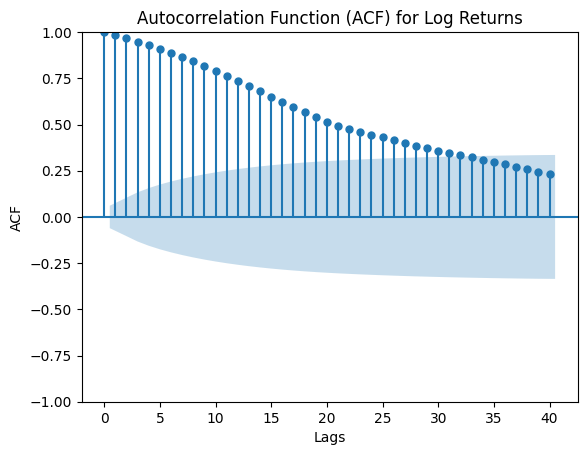

In [65]:
# Calculate ACF values for the log stock returns
acf_values = sm.tsa.stattools.acf(vol_df_3['Daily_Volatility'], fft=False)

# Print the ACF values
print("ACF values:", acf_values)

# Plot the ACF
plot_acf(vol_df_3['Daily_Volatility'], lags=40)  # You can adjust the number of lags as needed
plt.title('Autocorrelation Function (ACF) for Log Returns')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

PACF values: [ 1.          0.98493879 -0.04883297 -0.04231249 -0.08827046  0.0115616
 -0.03192651 -0.05958115 -0.00132506 -0.11119964 -0.0505982  -0.04162743
 -0.01833883 -0.00692606  0.00288847 -0.05129627  0.01786659  0.05498689
 -0.07699838  0.0184398   0.00338478 -0.01129409  0.4220477  -0.14727653
 -0.04180686 -0.01809495  0.00121462 -0.01475743 -0.0416461   0.02280274
 -0.06190262 -0.02633785 -0.04786951 -0.01775216 -0.0042168  -0.0051755
 -0.02429521 -0.02399418 -0.01909416 -0.01892013  0.01538182]


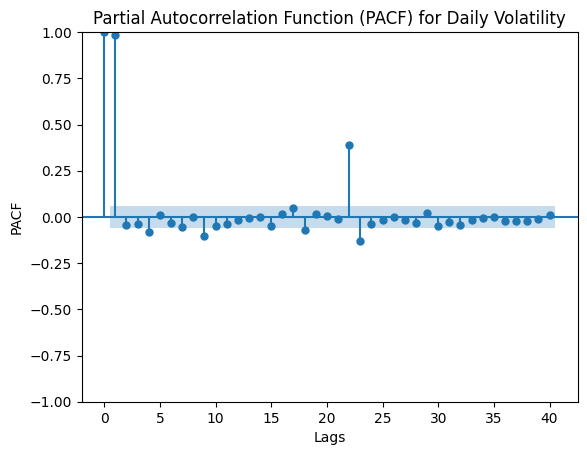

In [66]:
# Calculate ACF values for the log stock returns
pacf_values_vix = sm.tsa.stattools.pacf(vol_df_3['Daily_Volatility'], method='yw', nlags=40)

# Print the ACF values
print("PACF values:", pacf_values_vix)

# Plot the ACF
plot_pacf(vol_df_3['Daily_Volatility'], lags=40)  # You can adjust the number of lags as needed
plt.title('Partial Autocorrelation Function (PACF) for Daily Volatility')
plt.xlabel('Lags')
plt.ylabel('PACF')
plt.show()

In [67]:
vol_df_3['Daily_Volatility_Lag1'] = vol_df_3['Daily_Volatility'].shift(1)
vol_df_3['Daily_Volatility_Lag2'] = vol_df_3['Daily_Volatility'].shift(2)
vol_df_3['Daily_Volatility_Lag3'] = vol_df_3['Daily_Volatility'].shift(3)
vol_df_3['Daily_Volatility_Lag4'] = vol_df_3['Daily_Volatility'].shift(4)
vol_df_3['Daily_Volatility_Lag9'] = vol_df_3['Daily_Volatility'].shift(9)
vol_df_3['Daily_Volatility_Lag22'] = vol_df_3['Daily_Volatility'].shift(22)


In [68]:
vol_df_3 = pd.merge(vol_df_3, mxeu_df, on='Date', how='left')
vol_df_3 = pd.merge(vol_df_3, smi_df, on='Date', how='left')
vol_df_3 = pd.merge(vol_df_3, spx_df, on='Date', how='left')
vol_df_3 = pd.merge(vol_df_3, sx7p_df, on='Date', how='left')

In [69]:
vol_df_3

,Date,PX_LAST,PX_VOLUME,Log_Return,D_AVG,Positive_sentiment,Negative_sentiment,Positive_sentiment_0,Negative_sentiment_0,Daily_Volatility,...,Daily_Volatility_Lag1,Daily_Volatility_Lag2,Daily_Volatility_Lag3,Daily_Volatility_Lag4,Daily_Volatility_Lag9,Daily_Volatility_Lag22,Log_Return_MXEU,Log_Return_SMI,Log_Return_SPX,Log_Return_SX7P
0,2019-01-31,12.850,20282717.0,-0.019268,0.50,1.0,0.0,1.0,0.0,0.014134,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.001590,0.000397,0.003242,-0.022447
1,2019-02-01,12.840,14587804.0,-0.000779,0.00,0.0,0.0,1.0,1.0,0.014147,...,0.014134,NaN,NaN,NaN,NaN,NaN,0.005531,0.003016,0.001703,-0.002016
2,2019-02-04,12.715,10825933.0,-0.009783,1.00,1.0,0.0,1.0,0.0,0.012791,...,0.014147,0.014134,NaN,NaN,NaN,NaN,0.000705,0.001679,0.010166,-0.006225
3,2019-02-05,13.015,13382009.0,0.023320,0.00,0.0,0.0,0.0,0.0,0.013755,...,0.012791,0.014147,0.014134,NaN,NaN,NaN,0.014785,0.015316,0.006999,0.015130
4,2019-02-06,13.055,8278367.0,0.003069,1.00,1.0,0.0,1.0,0.0,0.013723,...,0.013755,0.012791,0.014147,0.014134,NaN,NaN,-0.000092,-0.000827,-0.000928,0.008545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038,2023-03-13,17.710,28227523.0,-0.079739,0.00,0.0,0.0,1.0,1.0,0.021304,...,0.013744,0.009774,0.009694,0.009324,0.009733,0.011397,-0.025970,-0.012451,-0.010036,-0.062257
1039,2023-03-14,18.340,16297012.0,0.034955,-1.00,0.0,1.0,0.0,1.0,0.023057,...,0.021304,0.013744,0.009774,0.009694,0.008559,0.011427,0.017588,0.007932,0.019411,0.027149
1040,2023-03-15,16.740,27387600.0,-0.091283,0.00,0.0,0.0,0.0,0.0,0.029035,...,0.023057,0.021304,0.013744,0.009774,0.008639,0.011418,-0.027369,-0.018869,0.011320,-0.069954
1041,2023-03-16,17.310,26105212.0,0.033483,0.25,0.0,0.0,1.0,0.0,0.030414,...,0.029035,0.023057,0.021304,0.013744,0.009647,0.011227,0.016229,0.019091,0.018483,0.015289


In [70]:
del vol_df_3['VIX_Volume']
vol_df_3

,Date,PX_LAST,PX_VOLUME,Log_Return,D_AVG,Positive_sentiment,Negative_sentiment,Positive_sentiment_0,Negative_sentiment_0,Daily_Volatility,...,Daily_Volatility_Lag1,Daily_Volatility_Lag2,Daily_Volatility_Lag3,Daily_Volatility_Lag4,Daily_Volatility_Lag9,Daily_Volatility_Lag22,Log_Return_MXEU,Log_Return_SMI,Log_Return_SPX,Log_Return_SX7P
0,2019-01-31,12.850,20282717.0,-0.019268,0.50,1.0,0.0,1.0,0.0,0.014134,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.001590,0.000397,0.003242,-0.022447
1,2019-02-01,12.840,14587804.0,-0.000779,0.00,0.0,0.0,1.0,1.0,0.014147,...,0.014134,NaN,NaN,NaN,NaN,NaN,0.005531,0.003016,0.001703,-0.002016
2,2019-02-04,12.715,10825933.0,-0.009783,1.00,1.0,0.0,1.0,0.0,0.012791,...,0.014147,0.014134,NaN,NaN,NaN,NaN,0.000705,0.001679,0.010166,-0.006225
3,2019-02-05,13.015,13382009.0,0.023320,0.00,0.0,0.0,0.0,0.0,0.013755,...,0.012791,0.014147,0.014134,NaN,NaN,NaN,0.014785,0.015316,0.006999,0.015130
4,2019-02-06,13.055,8278367.0,0.003069,1.00,1.0,0.0,1.0,0.0,0.013723,...,0.013755,0.012791,0.014147,0.014134,NaN,NaN,-0.000092,-0.000827,-0.000928,0.008545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038,2023-03-13,17.710,28227523.0,-0.079739,0.00,0.0,0.0,1.0,1.0,0.021304,...,0.013744,0.009774,0.009694,0.009324,0.009733,0.011397,-0.025970,-0.012451,-0.010036,-0.062257
1039,2023-03-14,18.340,16297012.0,0.034955,-1.00,0.0,1.0,0.0,1.0,0.023057,...,0.021304,0.013744,0.009774,0.009694,0.008559,0.011427,0.017588,0.007932,0.019411,0.027149
1040,2023-03-15,16.740,27387600.0,-0.091283,0.00,0.0,0.0,0.0,0.0,0.029035,...,0.023057,0.021304,0.013744,0.009774,0.008639,0.011418,-0.027369,-0.018869,0.011320,-0.069954
1041,2023-03-16,17.310,26105212.0,0.033483,0.25,0.0,0.0,1.0,0.0,0.030414,...,0.029035,0.023057,0.021304,0.013744,0.009647,0.011227,0.016229,0.019091,0.018483,0.015289


In [71]:
vol_df_3.replace([np.inf, -np.inf], np.nan, inplace=True)
vol_df_3.dropna(inplace=True)

In [72]:

# Define the model with sentiment scores and lagged returns as predictors
X = vol_df_3[['Positive_sentiment', 'Negative_sentiment', 'VIX_price', 'Daily_Volatility_Lag1','Daily_Volatility_Lag2' ,'Daily_Volatility_Lag3','Daily_Volatility_Lag4','Daily_Volatility_Lag9','Daily_Volatility_Lag22','Log_Return_MXEU', 'Log_Return_SMI', 'Log_Return_SPX', 'Log_Return_SX7P']]
X = sm.add_constant(X)  # Adding a constant
y = vol_df_3['Daily_Volatility']

# Fit the model
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Daily_Volatility   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1691.
Date:                Mon, 29 Jul 2024   Prob (F-statistic):               0.00
Time:                        22:37:36   Log-Likelihood:                 5135.6
No. Observations:                1003   AIC:                        -1.024e+04
Df Residuals:                     989   BIC:                        -1.017e+04
Df Model:                          13                                         
Covariance Type:                  HAC                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [ ]:
# repeat steps and only calculate relevant lags


In [80]:
vol_df_4 = vol_df_2.copy()


In [81]:
vol_df_4 = pd.merge(vol_df_4, vix, on='Date', how='left')


In [82]:
vol_df_4['Daily_Volatility_Lag1'] = vol_df_4['Daily_Volatility'].shift(1)
vol_df_4['Daily_Volatility_Lag9'] = vol_df_4['Daily_Volatility'].shift(9)
vol_df_4['Daily_Volatility_Lag22'] = vol_df_4['Daily_Volatility'].shift(22)

In [83]:
vol_df_4 = pd.merge(vol_df_4, mxeu_df, on='Date', how='left')
vol_df_4 = pd.merge(vol_df_4, smi_df, on='Date', how='left')
vol_df_4 = pd.merge(vol_df_4, spx_df, on='Date', how='left')
vol_df_4 = pd.merge(vol_df_4, sx7p_df, on='Date', how='left')

In [84]:
del vol_df_4['VIX_Volume']

In [85]:
vol_df_4.replace([np.inf, -np.inf], np.nan, inplace=True)
vol_df_4.dropna(inplace=True)

In [87]:

# Define the model with sentiment scores and lagged returns as predictors
X = vol_df_4[['Positive_sentiment', 'Negative_sentiment', 'VIX_price', 'Daily_Volatility_Lag1','Daily_Volatility_Lag9','Daily_Volatility_Lag22','Log_Return_MXEU', 'Log_Return_SMI', 'Log_Return_SPX', 'Log_Return_SX7P']]
X = sm.add_constant(X)  # Adding a constant
y = vol_df_4['Daily_Volatility']

# Fit the model
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Daily_Volatility   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     2207.
Date:                Mon, 29 Jul 2024   Prob (F-statistic):               0.00
Time:                        22:41:55   Log-Likelihood:                 5133.4
No. Observations:                1003   AIC:                        -1.024e+04
Df Residuals:                     992   BIC:                        -1.019e+04
Df Model:                          10                                         
Covariance Type:                  HAC                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0